In [1]:
import pandas as pd

In [2]:
# %pip install tensorflow[and-cuda]

In [3]:
import os

dir_notebook = os.getcwd()
print(dir_notebook)

/home/david/proyectos4/repositorios/Proyectos-SGBA1/Pruebas/Modelos/precio_peninsula


In [4]:
ruta_trabajo = '../../../'

# Cambiar el directorio de trabajo
os.chdir(ruta_trabajo)

print("Directorio de trabajo actual:", os.getcwd())

Directorio de trabajo actual: /home/david/proyectos4/repositorios/Proyectos-SGBA1


In [5]:
!pwd

/home/david/proyectos4/repositorios/Proyectos-SGBA1


### Cargar df_clima_precio 

In [6]:
df_precio = pd.read_parquet('data/processed/datos_precio/clima_precio_merged.parquet')

In [7]:
# !pip install numpy pandas scikit-learn tensorflow xgboost lightgbm matplotlib

In [8]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from tensorflow.keras.layers import LSTM, Dense, Dropout

import matplotlib.pyplot as plt

2025-03-26 18:46:38.626763: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743011198.639026   47715 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743011198.642459   47715 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743011198.652669   47715 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743011198.652693   47715 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743011198.652694   47715 computation_placer.cc:177] computation placer alr

In [9]:
df_precio.columns

Index(['timestamp', '€/kwh', 'fecha', 'indicativo_3196', 'altitud_3196',
       'tmed_3196', 'tmin_3196', 'tmax_3196', 'velmedia_3196', 'racha_3196',
       ...
       'horaPresMax_cos_8175', 'horaPresMin_varias_8175',
       'horaPresMin_minutos_8175', 'horaPresMin_sin_8175',
       'horaPresMin_cos_8175', 'prec_inapreciable_8175', 'prec_valor_8175',
       'prec_log_8175', 'dir_sin_8175', 'dir_cos_8175'],
      dtype='object', length=516)

In [10]:
# Identify numeric and non-numeric columns
numeric_cols = df_precio.select_dtypes(include=['float64', 'int64']).columns
non_numeric_cols = df_precio.select_dtypes(exclude=['float64', 'int64']).columns

print("Non-numeric columns:", non_numeric_cols)
print(df_precio[non_numeric_cols].head())

# Remove all non-numeric columns except 'fecha'
columns_to_drop = [col for col in non_numeric_cols if col != 'fecha']
df_precio_coor = df_precio.drop(columns_to_drop, axis=1, errors='ignore')
df_precio_coor = df_precio.drop(non_numeric_cols, axis=1, errors='ignore')


Non-numeric columns: Index(['timestamp', 'fecha', 'indicativo_6155A', 'horaHrMax_6155A',
       'horaHrMin_6155A', 'indicativo_3469A', 'horaHrMax_8019',
       'horaHrMin_8019', 'indicativo_0200E', 'horaHrMax_4121',
       'horaHrMin_4121', 'horaHrMax_8175', 'horaHrMin_8175'],
      dtype='object')
            timestamp      fecha indicativo_6155A horaHrMax_6155A  \
0 2014-11-03 14:00:00 2014-11-03            6155A          Varias   
1 2014-11-03 15:00:00 2014-11-03            6155A          Varias   
2 2014-11-03 16:00:00 2014-11-03            6155A          Varias   
3 2014-11-03 17:00:00 2014-11-03            6155A          Varias   
4 2014-11-03 18:00:00 2014-11-03            6155A          Varias   

  horaHrMin_6155A indicativo_3469A horaHrMax_8019 horaHrMin_8019  \
0          Varias            3469A         Varias          12:31   
1          Varias            3469A         Varias          12:31   
2          Varias            3469A         Varias          12:31   
3          Va

In [14]:
print(df_precio_coor.shape)
# Drop de las columnas que contengan la palabra indicativo y altitud
df_precio_coor = df_precio_coor.drop([col for col in df_precio_coor.columns if 'indicativo' in col], axis=1, errors='ignore')
df_precio_coor = df_precio_coor.drop([col for col in df_precio_coor.columns if 'altitud' in col], axis=1, errors='ignore')
df_precio_coor = df_precio_coor.drop([col for col in df_precio_coor.columns if 'hr' in col], axis=1, errors='ignore')
df_precio_coor = df_precio_coor.drop([col for col in df_precio_coor.columns if 'Hr' in col], axis=1, errors='ignore')
df_precio_coor = df_precio_coor.drop([col for col in df_precio_coor.columns if 'hora' in col], axis=1, errors='ignore')



print(df_precio_coor.shape)

(57625, 402)
(57625, 162)


Top 10 correlaciones con €/kwh:
velmedia_1505             0.012853
prec_inapreciable_1505    0.011212
prec_log_1505             0.011212
prec_valor_1505           0.011212
dir_sin_3469A             0.009587
dir_sin_0200E             0.008583
velmedia_8019             0.007689
racha_1505                0.007352
dir_cos_4121              0.007001
anio                      0.006963
Name: €/kwh, dtype: float64

Top 10 características más importantes según Random Forest:
           feature  importance
159   dir_sin_8175    0.102750
8             anio    0.082773
133  dir_sin_0200E    0.075554
101      sol_3469A    0.067667
140       sol_4121    0.066834
10             dia    0.049641
42    dir_sin_9170    0.048639
76   velmedia_5514    0.048251
86   velmedia_1505    0.047628
87      racha_1505    0.040080


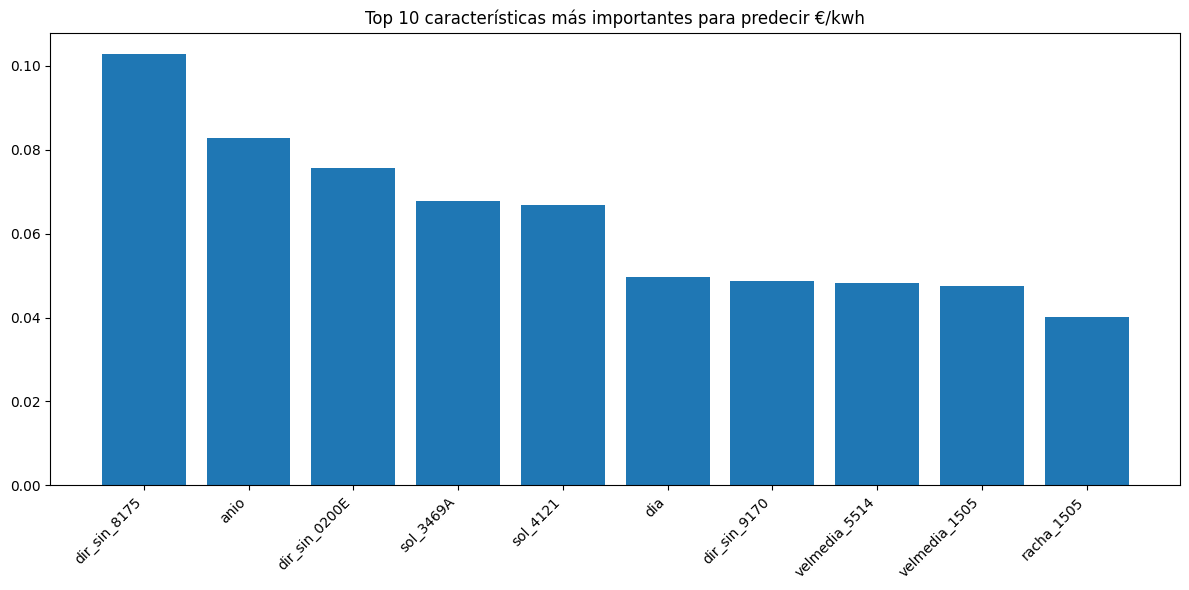

In [15]:
# Calculamos la correlación con €/kwh
correlations = df_precio_coor.corr()['€/kwh'].sort_values(ascending=False)

# Mostramos las 10 variables más correlacionadas (excluyendo la propia €/kwh)
print("Top 10 correlaciones con €/kwh:")
print(correlations[1:11])

# Usamos Random Forest para ver la importancia de las características
# Seleccionamos solo columnas numéricas
numeric_cols = df_precio_coor.select_dtypes(include=['float64', 'int64']).columns
X = df_precio_coor[numeric_cols].drop('€/kwh', axis=1)
y = df_precio_coor['€/kwh']

# Entrenamos un Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Obtenemos la importancia de las características
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
})

# Mostramos las 10 características más importantes según Random Forest
print("\nTop 10 características más importantes según Random Forest:")
print(feature_importance.sort_values('importance', ascending=False).head(10))

# Visualizamos las 10 características más importantes
plt.figure(figsize=(12, 6))
top_10_features = feature_importance.sort_values('importance', ascending=False).head(10)
plt.bar(top_10_features['feature'], top_10_features['importance'])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 características más importantes para predecir €/kwh')
plt.tight_layout()
plt.show()

In [ ]:
# Ordenar por fecha
df_precio = df_precio.sort_values('fecha')

# Seleccionar todas las columnas numéricas excepto la variable objetivo
X = df_precio_coor.drop('€/kwh', axis=1)
y = df_precio['€/kwh']

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
# Select top 20 most important features
# Get temperature, sun and wind related features
selected_features = [col for col in X.columns if any(x in col for x in ['tmed', 'sol', 'velmedia'])]
X_reduced = X_scaled[:, [list(X.columns).index(feat) for feat in selected_features]]

# Create sequences with reduced features
def create_sequences(X, y, seq_length=72, batch_size=1000):
    n_samples = len(X) - seq_length
    X_seq = np.zeros((n_samples, seq_length, X.shape[1]))
    y_seq = np.zeros(n_samples)
    
    for i in range(0, n_samples, batch_size):
        end_idx = min(i + batch_size, n_samples)
        for j in range(i, end_idx):
            X_seq[j] = X[j:j+seq_length]
            y_seq[j] = y[j+seq_length]
            
    return X_seq, y_seq

X_seq, y_seq = create_sequences(X_reduced, y.values)

# Print the shape of the sequences
print("X_seq shape:", X_seq.shape)
print("y_seq shape:", y_seq.shape)

In [ ]:
selected_features

In [ ]:
%pip install optuna

In [ ]:
import optuna
from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error
import numpy as np

# Definir función objetivo para Optuna
def objective(trial):
    # Definir el espacio de búsqueda de hiperparámetros
    lstm_units = trial.suggest_int('lstm_units', 20, 64)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    
    # Inicializar TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=3)  # You can adjust the number of splits
    
    mse_scores = []
    
    # Loop through each fold in TimeSeriesSplit
    for train_idx, val_idx in tscv.split(X_seq):
        X_train, X_val = X_seq[train_idx], X_seq[val_idx]
        y_train, y_val = y_seq[train_idx], y_seq[val_idx]
        
        # Definir el modelo LSTM con los hiperparámetros sugeridos
        model = Sequential([
            Input(shape=(72, len(selected_features))),  # Specify the input shape here
            LSTM(lstm_units, activation='relu'),
            Dropout(dropout_rate),
            Dense(1)
        ])
        
        # Compilar el modelo
        model.compile(optimizer='adam', loss='mse')
        
        # Entrenar el modelo
        model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=0)
        
        # Evaluar el modelo en el conjunto de validación
        y_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        mse_scores.append(mse)
    
    # Return the mean MSE across all folds
    return np.mean(mse_scores)

# Ejecutar la optimización con Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Imprimir los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:")
print(study.best_params)

# Imprimir el mejor valor de la función objetivo
print("Mejor MSE:")
print(study.best_value)

# Entrenar el modelo final con los mejores hiperparámetros
best_lstm_units = study.best_params['lstm_units']
best_dropout_rate = study.best_params['dropout_rate']

final_model = Sequential([
    LSTM(best_lstm_units, input_shape=(72, len(selected_features)), activation='relu'),
    Dropout(best_dropout_rate),
    Dense(1)
])

final_model.compile(optimizer='adam', loss='mse')

# Reentrenar con todos los datos
final_model.fit(X_seq, y_seq, epochs=10, batch_size=32)

# Validación cruzada con series temporales (usando el modelo final)
tscv = TimeSeriesSplit(n_splits=3)
results = {'LSTM_Optuna': {'mse': [], 'mae': [], 'r2': []}}

for train_idx, test_idx in tscv.split(X_seq):
    X_train, X_test = X_seq[train_idx], X_seq[test_idx]
    y_train, y_test = y_seq[train_idx], y_seq[test_idx]
    
    # Usar el modelo entrenado con Optuna
    y_pred = final_model.predict(X_test)
    
    # Calcular métricas
    results['LSTM_Optuna']['mse'].append(mean_squared_error(y_test, y_pred))
    results['LSTM_Optuna']['mae'].append(mean_absolute_error(y_test, y_pred))
    results['LSTM_Optuna']['r2'].append(r2_score(y_test, y_pred))

In [ ]:
# Mostrar resultados
for model_name in results:
    print(f"\nResultados para {model_name}:")
    print(f"MSE medio: {np.mean(results[model_name]['mse']):.4f} ± {np.std(results[model_name]['mse']):.4f}")
    print(f"MAE medio: {np.mean(results[model_name]['mae']):.4f} ± {np.std(results[model_name]['mae']):.4f}")
    print(f"R2 medio: {np.mean(results[model_name]['r2']):.4f} ± {np.std(results[model_name]['r2']):.4f}")

# Visualizar comparación de modelos
plt.figure(figsize=(10, 6))
for model_name in results:
    plt.plot(results[model_name]['mae'], label=model_name)
plt.xlabel('Fold')
plt.ylabel('MAE')
plt.title('Comparación de MAE por modelo')
plt.legend()
plt.show()